Load in libraries

In [21]:
import pandas as pd
from itertools import takewhile
import plotly.graph_objects as go
import plotly.express as px
import base64
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt
from numpy import loadtxt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from fig_mods.nextstep import areagrid

Read in InTEM data

In [12]:
ds_flux = xr.open_dataset("data/flux_data.nc")

## Set the longitude and latitude to only include the UK;

min_lon = -12
min_lat = 48
max_lon = 5 
max_lat = 62 

ds_flux = ds_flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
ds_flux

<xarray.Dataset>
Dimensions:             (time: 48, lon: 48, lat: 60, country: 1)
Coordinates:
  * time                (time) datetime64[ns] 2012-01-01 ... 2015-12-01
  * lon                 (lon) float32 -11.66 -11.31 -10.96 ... 4.18 4.532 4.884
  * lat                 (lat) float32 48.17 48.4 48.64 ... 61.51 61.74 61.98
Dimensions without coordinates: country
Data variables:
    country_name        (country) |S2 ...
    flux_mean           (lat, lon, time) float32 ...
    flux_std            (lat, lon, time) float32 ...
    flux_prior          (lat, lon, time) float32 ...
    flux_std_prior      (lat, lon, time) float32 ...
    country_post_mean   (country, time) float32 ...
    country_post_std    (country, time) float32 ...
    country_prior_mean  (country, time) float32 ...
    country_prior_std   (country, time) float32 ...
Attributes:
    history:           Created on 2022-09-22 15:28:48 by A. J. Manning
    molecular_weight:  16.0

In [3]:
lat = np.arange(48.169, 61.975, 0.234)
lon = np.arange(-11.66, 4.884, 0.352)
area = areagrid(lat, lon)
area

array([[6.78476540e+08, 6.78476540e+08, 6.78476540e+08, ...,
        6.78476540e+08, 6.78476540e+08, 6.78476540e+08],
       [6.75375129e+08, 6.75375129e+08, 6.75375129e+08, ...,
        6.75375129e+08, 6.75375129e+08, 6.75375129e+08],
       [6.72262452e+08, 6.72262452e+08, 6.72262452e+08, ...,
        6.72262452e+08, 6.72262452e+08, 6.72262452e+08],
       ...,
       [4.85306408e+08, 4.85306408e+08, 4.85306408e+08, ...,
        4.85306408e+08, 4.85306408e+08, 4.85306408e+08],
       [4.81650870e+08, 4.81650870e+08, 4.81650870e+08, ...,
        4.81650870e+08, 4.81650870e+08, 4.81650870e+08],
       [4.77987299e+08, 4.77987299e+08, 4.77987299e+08, ...,
        4.77987299e+08, 4.77987299e+08, 4.77987299e+08]])

In [4]:
## Create a function to produce a mean flux reading for each year;

def weighted_temporal_mean(ds, var):

    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    
    return obs_sum / ones_out

In [5]:
Intem_new_year = weighted_temporal_mean(ds_flux, "flux_prior")
#Intem_new_year

In [20]:
Intem2012 = Intem_new_year[dict(time=0)] * area
Intem2013 = Intem_new_year[dict(time=1)] * area
Intem2014 = Intem_new_year[dict(time=2)] * area
Intem2015 = Intem_new_year[dict(time=3)] * area
#Intem2012

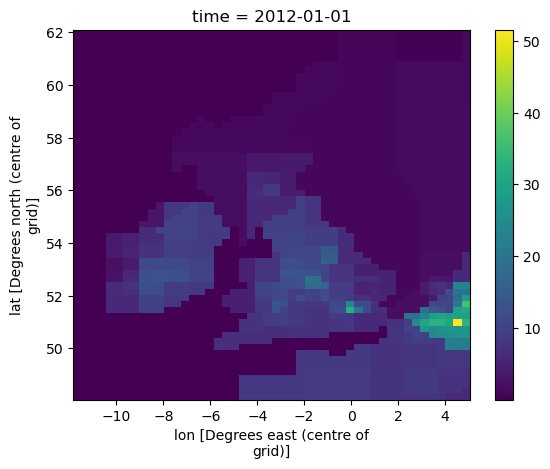

In [19]:
Intem2012.plot()

Read in inventory data

In [7]:
def read_invent_ch4(year, species):
    import pandas as pd
    from itertools import takewhile
    import plotly.graph_objects as go
    import base64
    import numpy as np
    import glob
    import xarray as xr
    
    csv = glob.glob(f"data/ch4-ukghg-{species}_EUROPE_{year}.nc")
    
    flux = xr.open_dataset(csv[0])
    
    min_lon = -12
    min_lat = 48
    max_lon = 5 
    max_lat = 62 
    
    cropped_ds = flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    cropped_ds = cropped_ds * area
    
    return cropped_ds

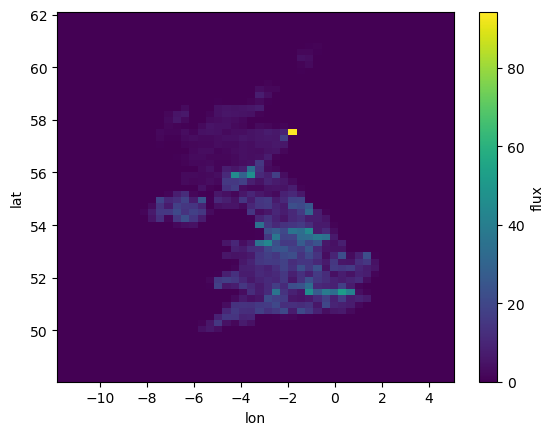

In [33]:
z = read_invent_ch4("2012", "total")
z.flux.plot()

In [34]:
z.flux.sum() * 16 * 31536000 * 28 / 1000000000000

<xarray.DataArray 'flux' ()>
array(73.06508562)

Plot InTEM sector maps (2012)

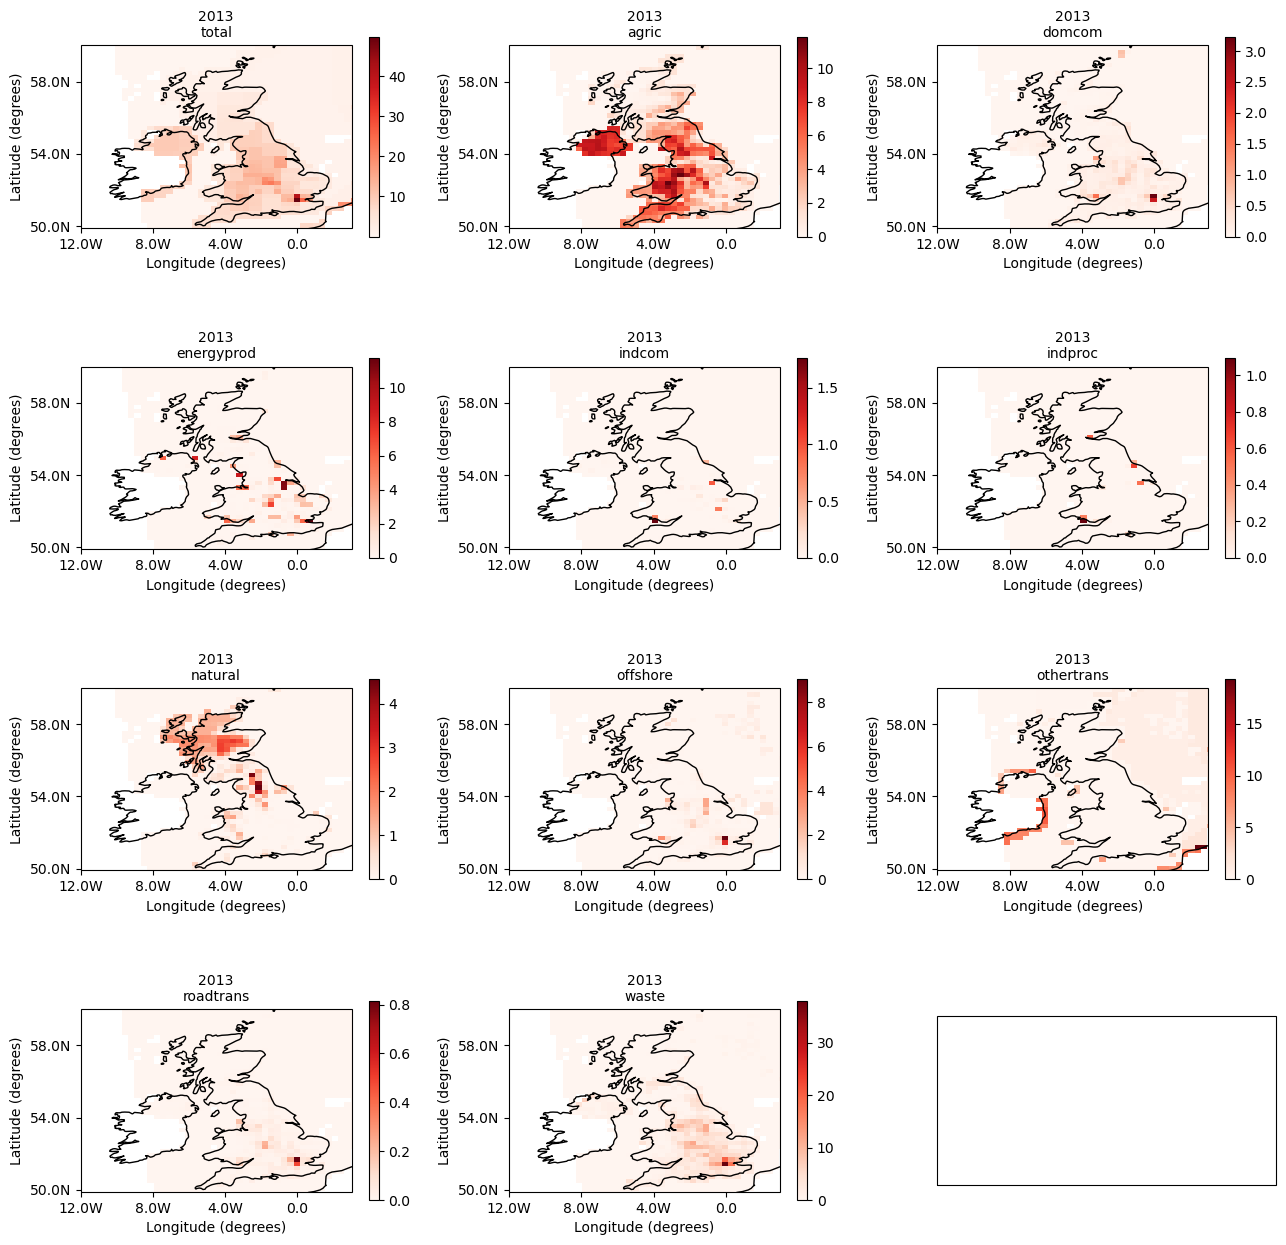

In [8]:
fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})

species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]

fontsizes = {"title":10, "labels": 10, "axis":10}

for name, ax in zip(species, axs.flatten()):
    
    a = read_invent_ch4("2013", name)
    b = read_invent_ch4("2013", "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    data = test * Intem2013
    
    a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap('Reds'))
    ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    
    ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)        
    # set y-ticks for the plot, and format          
    ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
    lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
    ax.yaxis.set_major_formatter(lat_formatter)             
    ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
    
    #ax.set_title(name)
    fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
    
    ax.set_title("2013" +"\n"+ name, fontsize = fontsizes["title"])
    ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
    ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])

fig.tight_layout()

In [65]:
def plot_sector(year):
    
    fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})
    
    species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]
    
    fontsizes = {"title":10, "labels": 10, "axis":10}
    
    for name, ax in zip(species, axs.flatten()):
        
        a = read_invent_ch4(year, name)
        b = read_invent_ch4(year, "total")
        
        fract = a.flux / b.flux
        test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
        
        if year == "2012":
            data = test * Intem2012
            x = 'Reds'
        elif year == "2013":
            data = test * Intem2013
            x = 'Blues'
        elif year == "2014":
            data = test * Intem2014
            x = 'Greens'
        elif year == "2015":
            data = test * Intem2015
            x = 'Purples'
                
        a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap(x))
        ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
        ax.coastlines(resolution='50m', color='black', linewidth=1)
        
        ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)        
        # set y-ticks for the plot, and format          
        ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
        lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
        ax.yaxis.set_major_formatter(lat_formatter)             
        ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
        
        fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
        
        ax.set_title("2013" +"\n"+ name, fontsize = fontsizes["title"])
        ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
        ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])
        
    fig.tight_layout()

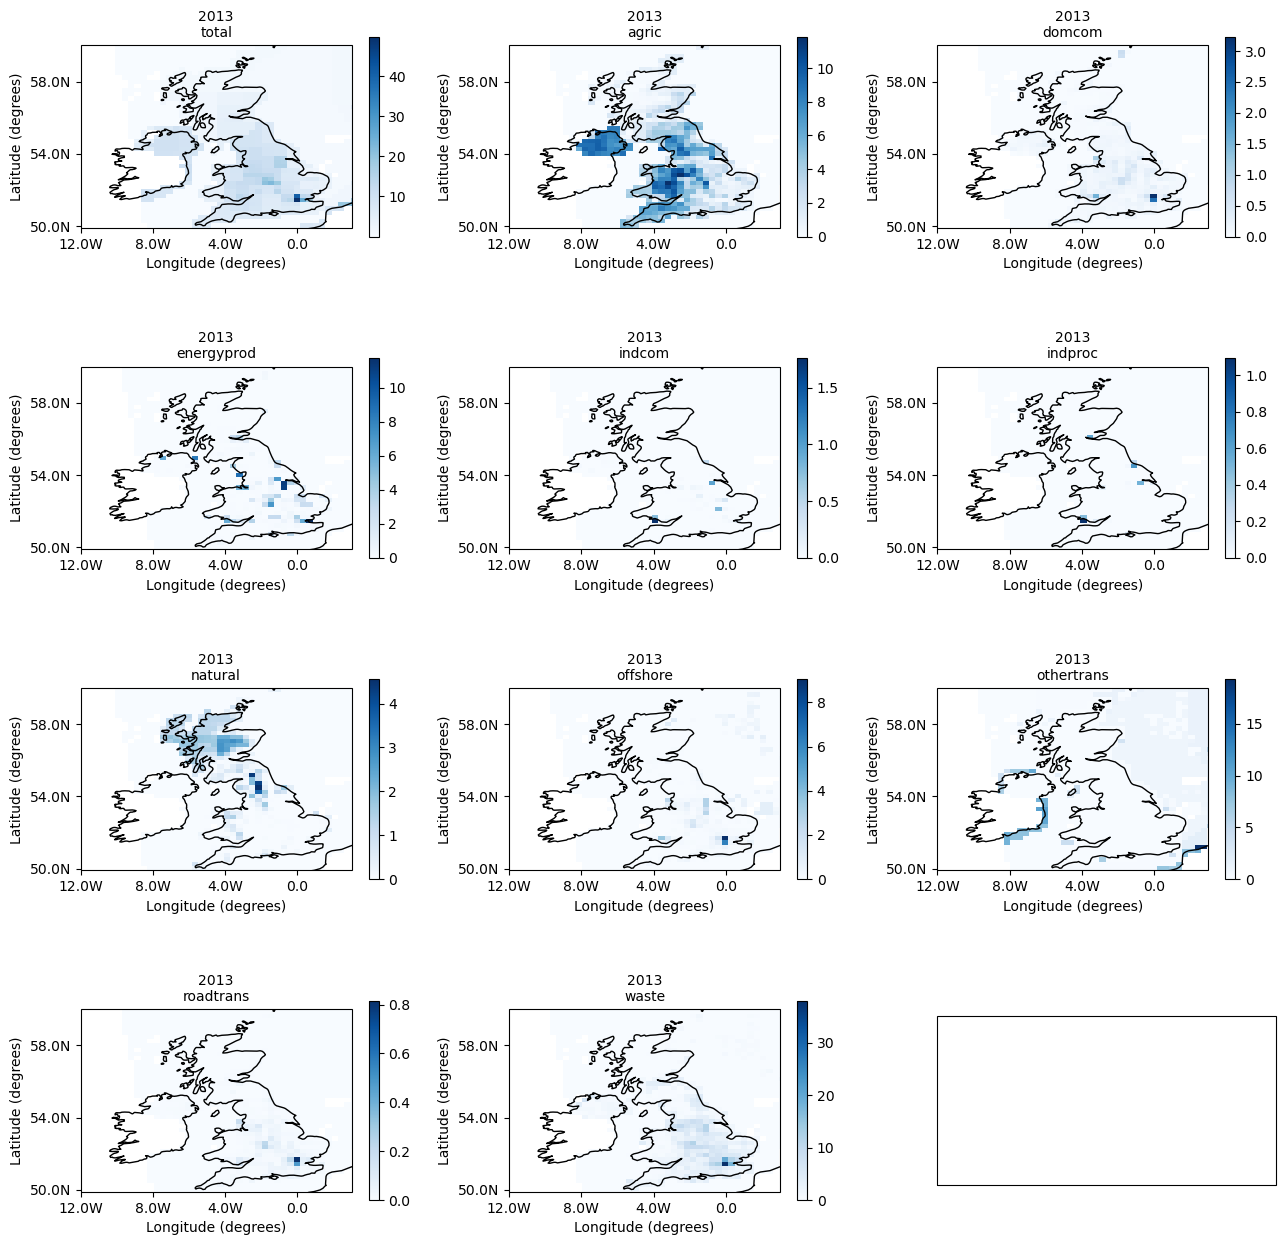

In [66]:
plot_sector("2013")

Percentage of total emissions

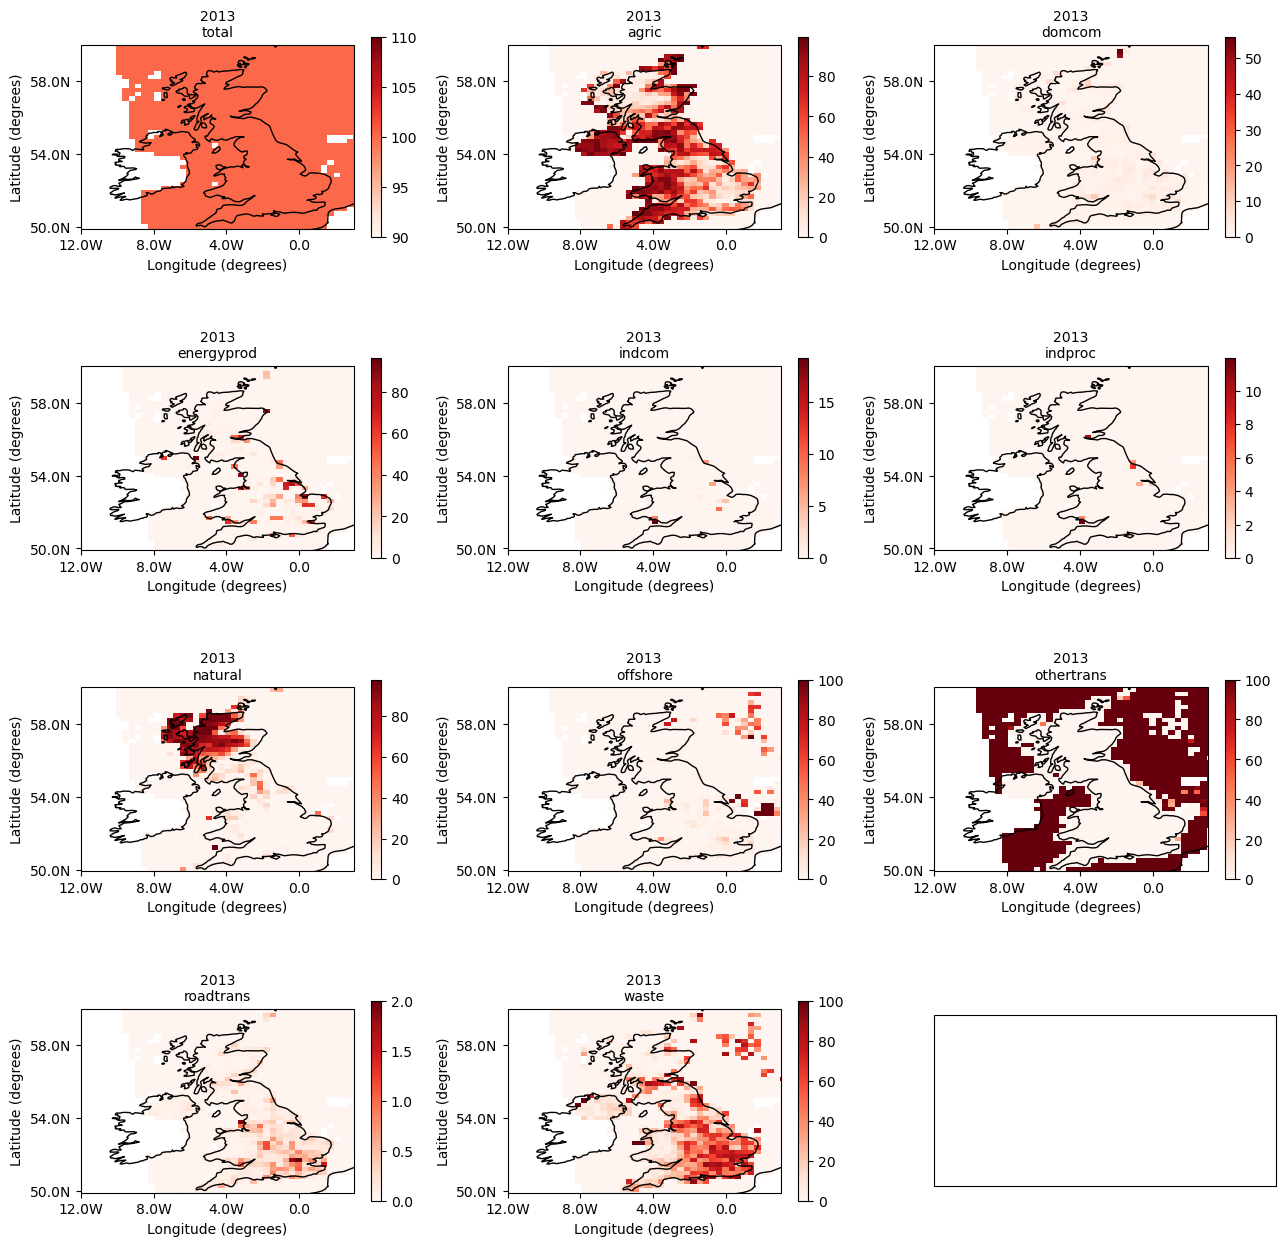

In [54]:
fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})

species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]

fontsizes = {"title":10, "labels": 10, "axis":10}

for name, ax in zip(species, axs.flatten()):
    
    a = read_invent_ch4("2013", name)
    b = read_invent_ch4("2013", "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    test1 = test * Intem2013
    
    data = test1 / Intem2013 * 100
    
    a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap('Reds'))
    ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    
    ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)        
    # set y-ticks for the plot, and format          
    ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
    lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
    ax.yaxis.set_major_formatter(lat_formatter)             
    ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
    
    #ax.set_title(name)
    fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
    
    ax.set_title("2013" +"\n"+ name, fontsize = fontsizes["title"])
    ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
    ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])

fig.tight_layout()

In [21]:
def plot_sector_perc(year):
    
    fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})
    
    species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]
    
    fontsizes = {"title":10, "labels": 10, "axis":10}
    
    for name, ax in zip(species, axs.flatten()):
        
        a = read_invent_ch4(year, name)
        b = read_invent_ch4(year, "total")
        
        fract = a.flux / b.flux
        test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
        
        if year == "2012":
            test1 = test * Intem2012
            data = test1 / Intem2012 * 100
            x = 'Reds'
        elif year == "2013":
            test1 = test * Intem2013
            data = test1 / Intem2013 * 100
            x = 'Blues'
        elif year == "2014":
            test1 = test * Intem2014
            data = test1 / Intem2014 * 100
            x = 'Greens'
        elif year == "2015":
            test1 = test * Intem2015
            data = test1 / Intem2015 * 100
            x = 'Purples'
                
        a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap(x))
        ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
        ax.coastlines(resolution='50m', color='black', linewidth=1)
        
        ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)        
        # set y-ticks for the plot, and format          
        ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
        lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
        ax.yaxis.set_major_formatter(lat_formatter)             
        ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
    
        ax.set_title(year +"\n"+ name, fontsize = fontsizes["title"])
        fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
        ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
        ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])
        
    fig.tight_layout()

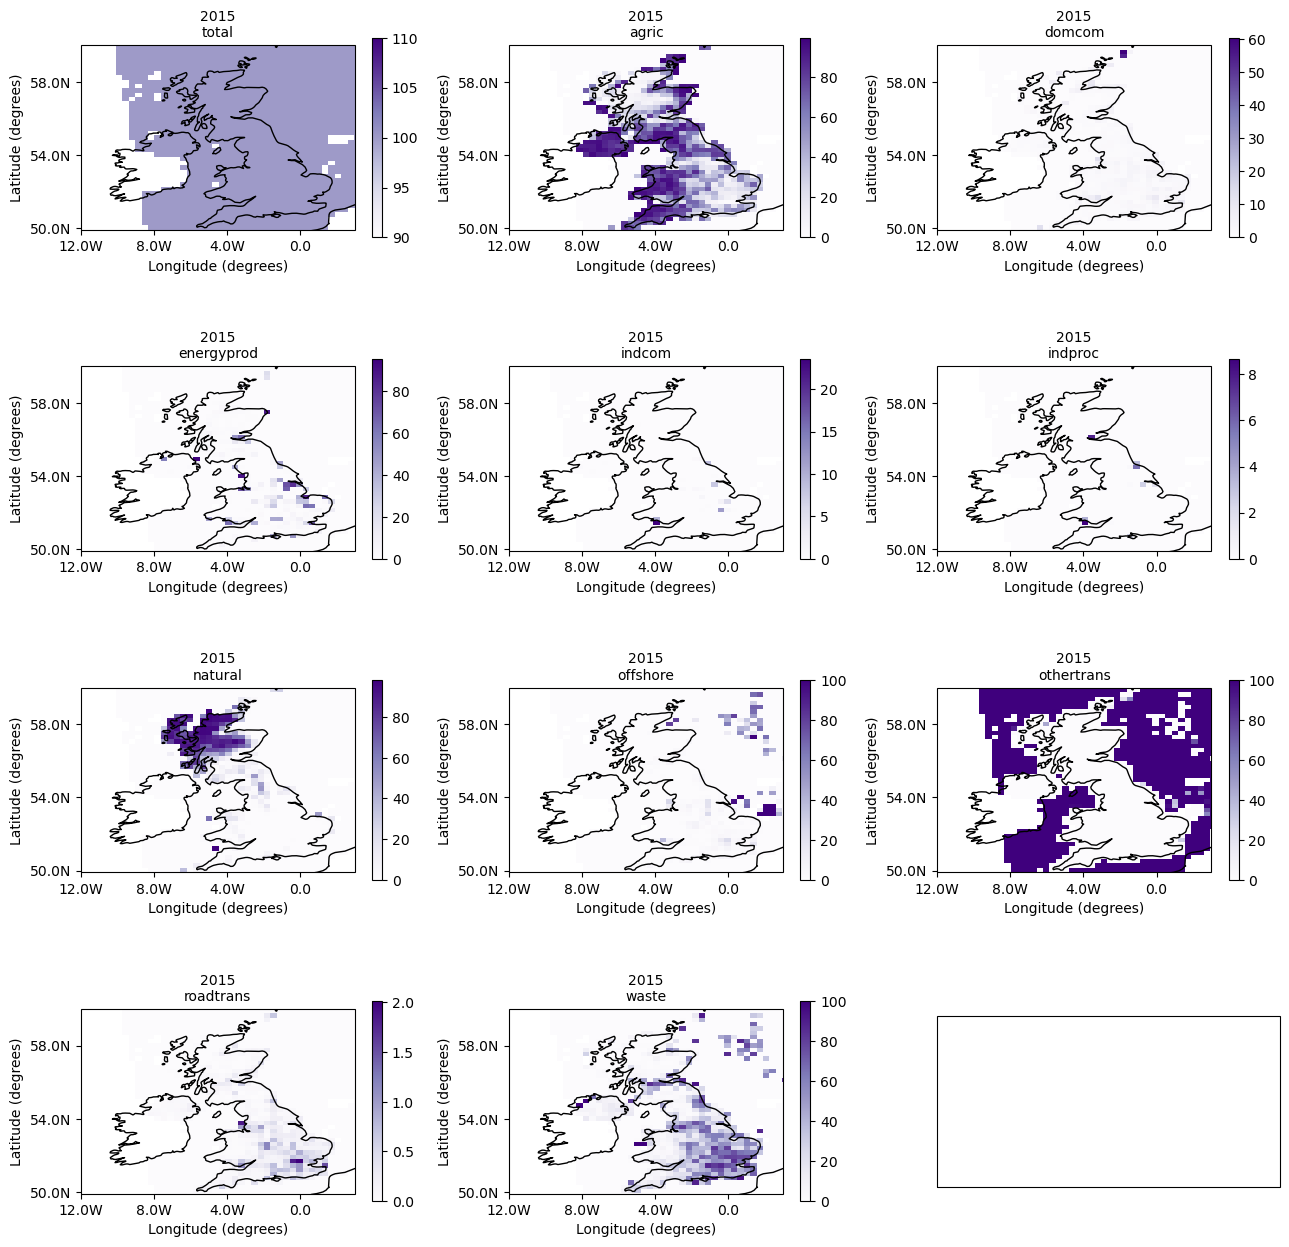

In [22]:
plot_sector_perc("2015")

Line graph

In [9]:
years = ["2012", "2013", "2014", "2015"]

for name, in zip(years):
    
    a = read_invent_ch4(name, "domcom")
    b = read_invent_ch4(name, "energyprod")
    c = read_invent_ch4(name, "offshore")
    d = read_invent_ch4(name, "othertrans")
    e = read_invent_ch4(name, "roadtrans")
    f = read_invent_ch4(name, "total")
    
    fract = a.flux + b.flux + c.flux + d.flux + e.flux / f.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if name == "2012":
        tenerg12 = test * Intem2012
        te12 = tenerg12.sum()
    if name == "2013":
        tenerg13 = test * Intem2013
        te13 = tenerg13.sum()
    if name == "2014":
        tenerg14 = test * Intem2014
        te14 = tenerg14.sum()
    if name == "2015":
        tenerg15 = test * Intem2015
        te15 = tenerg15.sum()
    
te = xr.concat((te12, te13, te14, te15), dim="time")

In [10]:
te * 16 * 31536000 * 28 / 10000000000000

<xarray.DataArray (time: 4)>
array([10.05763949,  9.16568648,  8.9977795 ,  7.93407223])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2013-01-01 2014-01-01 2015-01-01

In [11]:
years = ["2012", "2013", "2014", "2015"]

for name, ax in zip(years, axs.flatten()):
    
    a = read_invent_ch4(name, "indcom")
    c = read_invent_ch4(name, "indproc")
    b = read_invent_ch4(name, "total")
    
    fract = a.flux + c.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if name == "2012":
        tind12 = test * Intem2012
        ti12 = tind12.sum()
    if name == "2013":
        tind13 = test * Intem2013
        ti13 = tind13.sum()
    if name == "2014":
        tind14 = test * Intem2014
        ti14 = tind14.sum()
    if name == "2015":
        tind15 = test * Intem2015
        ti15 = tind15.sum()
    
tind = xr.concat((ti12, ti13, ti14, ti15), dim="time")

In [12]:
tind* 16 * 31536000 * 28 / 1000000000000

<xarray.DataArray (time: 4)>
array([1.42969701, 1.53112183, 1.5709113 , 1.47352184])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2013-01-01 2014-01-01 2015-01-01

In [13]:
years = ["2012", "2013", "2014", "2015"]

for name, ax in zip(years, axs.flatten()):
    
    a = read_invent_ch4(name, "agric")
    b = read_invent_ch4(name, "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if name == "2012":
        tagri12 = test * Intem2012
        ta12 = tagri12.sum()
    if name == "2013":
        tagri13 = test * Intem2013
        ta13 = tagri13.sum()
    if name == "2014":
        tagri14 = test * Intem2014
        ta14 = tagri14.sum()
    if name == "2015":
        tagri15 = test * Intem2015
        ta15 = tagri15.sum()
    
ta = xr.concat((ta12, ta13, ta14, ta15), dim="time")

In [14]:
ta * 16 * 31536000 * 28 / 1000000000000

<xarray.DataArray (time: 4)>
array([26.23546556, 26.32174275, 26.92469977, 27.24097646])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2013-01-01 2014-01-01 2015-01-01

In [15]:
years = ["2012", "2013", "2014", "2015"]

for name, ax in zip(years, axs.flatten()):
    
    a = read_invent_ch4(name, "natural")
    b = read_invent_ch4(name, "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if name == "2012":
        tLULUCF12 = test * Intem2012
        tLU12 = tLULUCF12.sum()
    if name == "2013":
        tLULUCF13 = test * Intem2013
        tLU13 = tLULUCF13.sum()
    if name == "2014":
        tLULUCF14 = test * Intem2014
        tLU14 = tLULUCF14.sum()
    if name == "2015":
        tLULUCF15 = test * Intem2015
        tLU15 = tLULUCF15.sum()
    
tLULUCF = xr.concat((tLU12, tLU13, tLU14, tLU15), dim="time")

In [16]:
tLULUCF * 16 * 31536000 * 28 / 1000000000000

<xarray.DataArray (time: 4)>
array([3.42310963, 3.65264268, 3.29654351, 3.5368919 ])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2013-01-01 2014-01-01 2015-01-01

In [17]:
years = ["2012", "2013", "2014", "2015"]

for name, ax in zip(years, axs.flatten()):
    
    a = read_invent_ch4(name, "waste")
    b = read_invent_ch4(name, "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if name == "2012":
        twaste12 = test * Intem2012
        tw12 = twaste12.sum()
    if name == "2013":
        twaste13 = test * Intem2013
        tw13 = twaste13.sum()
    if name == "2014":
        twaste14 = test * Intem2014
        tw14 = twaste14.sum()
    if name == "2015":
        twaste15 = test * Intem2015
        tw15 = twaste15.sum()
    
twaste = xr.concat((tw12, tw13, tw14, tw15), dim="time")

In [18]:
twaste * 16 * 31536000 * 28 / 1000000000000

<xarray.DataArray (time: 4)>
array([17.52789259, 15.71236971, 14.69582   , 13.99590415])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2013-01-01 2014-01-01 2015-01-01

Plot Line Graph

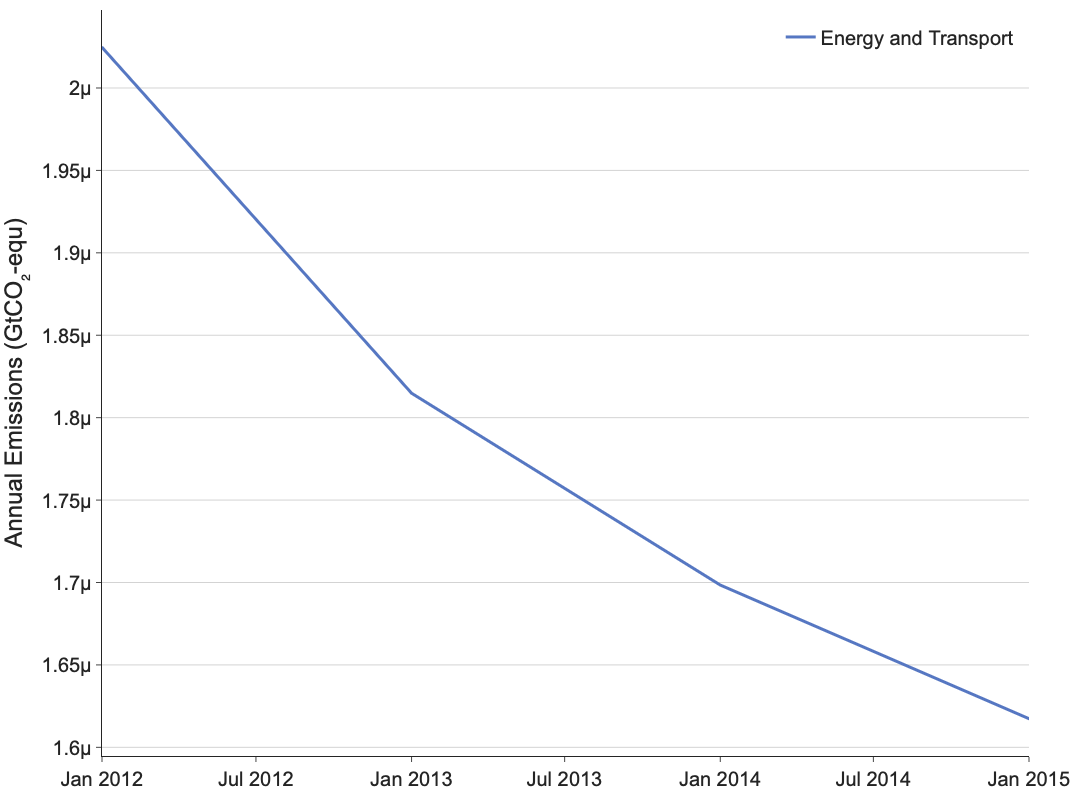

In [30]:
fig2 = go.Figure()

alpha = 0.6
color_1 = ["rgba(86, 119, 194, 1)", f"rgba(86, 119, 194, {alpha})"]
color_2 = ["rgba(99, 182, 137, 1)", f"rgba(99, 182, 137, {alpha})"]
color_3 = ["rgba(238,92,66, 1)", f"rgba(238,92,66, {alpha})"]
color_4 = ["rgba(255,215,0, 1)", f"rgba(255,215,0, {alpha})"]
color_5 = ["rgba(142,229,238, 1)", f"rgba(142,229,238, {alpha})"]
color_6 = ["rgba(169,169,169, 1)", f"rgba(169,169,169, {alpha})"]
color_7 = ["rgba(0, 0, 0, 1)", f"rgba(0, 0, 0, {alpha})"]

date_range = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
#date_range = ["2019-03-01", "2019-06-01"]

fig2.add_trace(go.Scatter(
    x=twaste.time,
    y=twaste.values,
    mode='lines',
    line=dict(color=color_1[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory Energy %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Energy and Transport",
    ))

fig2.update_layout(
    yaxis_title="Annual Emissions (GtCO₂-equ)",
    template="simple_white",
    autosize=False,
    width=550*2,
    height=400*2,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        traceorder="normal"),
    margin=dict(l=55, r=10, t=10, b=40),
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)'
)
    

fig2.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')

fig2.layout.font.size=20
fig2.layout.font.family="Arial"

#fig2.write_image("Annual_Emissions_by_sector.png")
#fig2.write_image("Annual_Emissions_by_sector.pdf")
#fig2.write_html("Annual_Emissions_by_sector.html")

fig2.show()

Tests - ignore

In [45]:
species = ["agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]

for name, ax in zip(species, axs.flatten()):
    
    a = read_invent_ch4("2012", name)
    b = read_invent_ch4("2012", "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    totalt = test * Intem2012

In [46]:
totalt.sum()

<xarray.DataArray ()>
array(2.02468759e-06)
Coordinates:
    time     datetime64[ns] 2012-01-01

In [41]:
a = read_invent_ch4("2012", "othertrans")
b = read_invent_ch4("2012", "roadtrans")
c = read_invent_ch4("2012", "total")

fract = a.flux + b.flux / c.flux
test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)

data1 = test * Intem2012

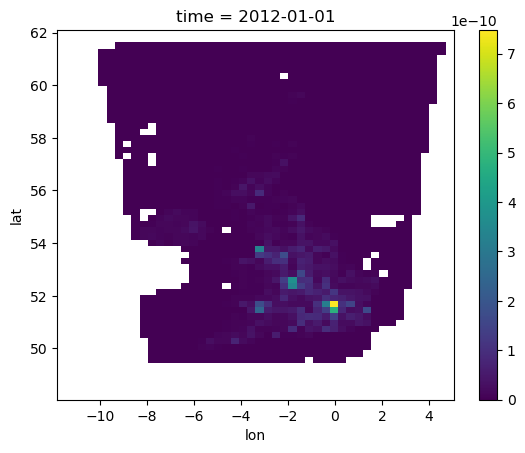

In [43]:
data1.plot()

In [ ]:
x = read_invent_ch4("2012", "agric")
y = read_invent_ch4("2012", "total")

z= x.flux * area

fract = z.flux / y.flux
test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)

data1 = test * Intem2012

In [18]:
x = read_invent_ch4("2012", "agric")
z = x.flux * area

In [19]:
z

<xarray.DataArray 'flux' (lat: 60, lon: 48)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., nan, nan,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float32 48.17 48.4 48.64 48.87 ... 61.27 61.51 61.74 61.97
  * lon      (lon) float32 -11.66 -11.31 -10.96 -10.6 ... 3.828 4.18 4.532 4.884

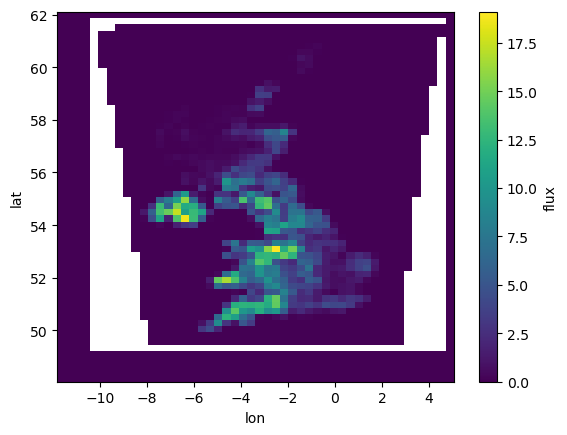

In [20]:
z.plot()